In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [7]:
# Read in data
df = pd.read_csv('/kaggle/input/bank-reviewcomplaint-analysis/BankReviews.csv', encoding='windows-1252')
print(df.shape)

(505, 4)


In [8]:
df.head()

,Date,Stars,Reviews,BankName
0,10-04-2017,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,10-02-2017,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,21-08-2017,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,17-12-2017,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,27-05-2016,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


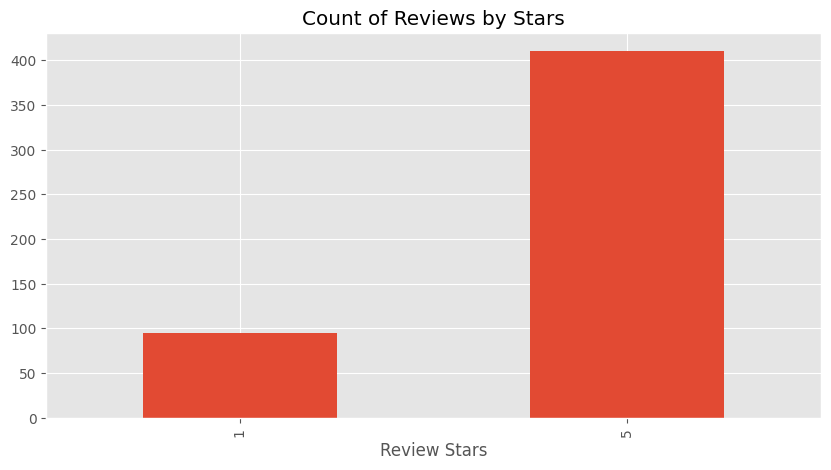

In [9]:
ax = df['Stars'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Roberta Pretrained Model

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [11]:
MODEL='cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL) #pulling down model weights stored at the time of training
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
df['Reviews'][0]

'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!'

In [13]:
encoded_text = tokenizer(df['Reviews'][0], return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0013393584, 'roberta_neu': 0.011199573, 'roberta_pos': 0.98746103}


In [29]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    return scores_dict

In [30]:
from tqdm.notebook import tqdm

results = {}
Id = 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        review = row['Reviews']  # Accessing review text for each row
        roberta_result = polarity_scores_roberta(review)
        results[Id] = roberta_result
        Id += 1
    except RuntimeError:
        print(f'Broke for ID {Id}')

  0%|          | 0/505 [00:00<?, ?it/s]

Broke for ID 138
Broke for ID 154
Broke for ID 226
Broke for ID 234
Broke for ID 496


In [31]:
result_df=pd.DataFrame(results)
result_df=result_df.T
result_df

,roberta_neg,roberta_neu,roberta_pos
0,0.001339,0.011200,0.987461
1,0.001494,0.009934,0.988572
2,0.003377,0.049706,0.946916
3,0.005911,0.072301,0.921787
4,0.002210,0.008817,0.988973
...,...,...,...
495,0.967096,0.030577,0.002328
496,0.673178,0.294047,0.032776
497,0.750257,0.206116,0.043627
498,0.154393,0.481288,0.364319


In [34]:
result_df = result_df
result_df = result_df.merge(df, how='left', left_index=True, right_index=True)


In [35]:
result_df

,roberta_neg,roberta_neu,roberta_pos,Date,Stars,Reviews,BankName
0,0.001339,0.011200,0.987461,10-04-2017,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,0.001494,0.009934,0.988572,10-02-2017,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,0.003377,0.049706,0.946916,21-08-2017,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,0.005911,0.072301,0.921787,17-12-2017,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,0.002210,0.008817,0.988973,27-05-2016,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage
...,...,...,...,...,...,...,...
495,0.967096,0.030577,0.002328,23-01-2016,1,\r\nStarted refinance with Nick things were go...,North American Savings Bank
496,0.673178,0.294047,0.032776,11-01-2017,1,\r\ncan someone explain why the APR is more th...,North American Savings Bank
497,0.750257,0.206116,0.043627,06-11-2016,1,"\r\nThis loan started off quite well. Our rep,...",North American Savings Bank
498,0.154393,0.481288,0.364319,27-05-2016,1,\r\nBuilt new home and wanted to get a small m...,North American Savings Bank


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

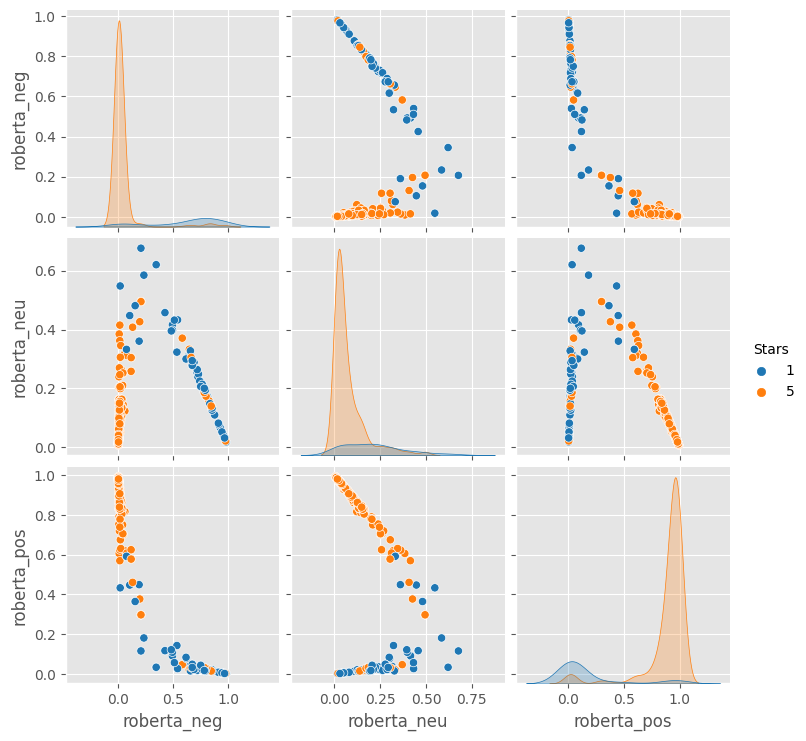

In [37]:
sns.pairplot(data=result_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Stars',
            palette='tab10')
plt.show()

## Predicting Sentiments using Pipeline